<a href="https://colab.research.google.com/github/ValentinVignal/HDStyleTransfert/blob/st%2Fgoogle-colab/style_transfert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HD Style transfert

## Utilisation

1. Create 1 folders on your computer names *content* and *style*
2. Put the corresponding images in it
3. Creat 2 `.zip` files: `content.zip` and `style.zip`
4. Import them in the session (column on the left)
5. Run everything

## What it does

It does all the combinaison of the content and style files and do the style transfert. It saves everything in the folder *results* with the architecture:
```bash
results/
 |- content_image_name1/
 |  |- style_image_name1/
 |  |  |- n_step.png          # The style transfered image at the step n
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- style_image_name2/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- ...
 |- content_image_name2/
 |  |- style_image_name1/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- style_image_name2/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- ...
 |- ...

```

## To keep the environment connected

1. Press `Ctrl` + ` Shift` + `i`
2. Go to *Console*
3. Paste these lines:
  ```javascript
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
  }
  setInterval(ClickConnect,60000);
  ```
4. Press `Enter`

## To allow the download

You need to enable third-party cookies but for now it only works for Chrome browser, open
```
chrome://settings/content/cookies
```
make sure the option for Block third-party cookies is disabled and click add button in Allow section then add
```
colab.research.google.com
```

# Parameters

You can customize the parameters by changing the value in the following dictionaries (the `None` value is considered as the default value).

Check out the default values in [this folder](https://github.com/ValentinVignal/HDStyleTransfert/tree/master/src/style_transfert/variables).

For the layers, here are all the choices: (use a conv block)

input_2 block1_conv1 block1_conv2 block1_pool block2_conv1 block2_conv2 block2_pool block3_conv1 block3_conv2 block3_conv3 block3_conv4 block3_pool block4_conv1 block4_conv2 block4_conv3 block4_conv4 block4_pool block5_conv1 block5_conv2 block5_conv3 block5_conv4 block5_pool


In [1]:
# Options
options = dict(
    st_mode=None,   # Mode of the style transfert
    image_start=['content']  # Options for the start image
)

In [2]:
# Parameters
parameters = dict(
  img_size=1024,   # Size of the generated image
  img_size_nn=None,
  dim_size='min',   # Axis of the chosen size of the image
  style_weight=None,    # Importance of style
  content_weight=None,    # Importance of content
  content_gram_weight=0,   # Importance of content when the start image is not the content image
  content_weight_multiplicator=2, # Multiply content importance when the starting image is not the content image
  total_variation_weight=None,   # How much to reduce high frequencies
  epochs=10,   # Number of epochs
  steps_per_epoch=None,    # Number of steps per epoch
  lr=None,    # Learning rate
  content_layers=None,   # List of names of the content layers
  content_gram_layers=None,    # The layers of the content gram
  style_layers=None,   # List of names of the style layers
  loss=None
)

In [3]:
do_list = True
parameters_list = [
  {
    "loss": "l2",
    "content_layers": ["block5_conv3"],
    "params": [
      {
        "content_weight": 1e6
      },
      {
       "content_weight": 1e5
      },
      {
       "content_weight": 1e4
      }
    ]
  }
]

In [4]:
# All parameters must be a list
do_grid = False
parameters_grid = dict(
    content_layers=[
      ['block5_conv3'],
      ['block4_conv3'],
      ['block3_conv3']
    ],
    # loss = ['l1', 'l2'],
    content_weight = [1e2, 1],
    style_weight = [1, 1e2],
    total_variation_weight=[1, 1e-1]
)


# Setup

In [5]:
# Install tensorflow
try:
  # %tensroflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.test.gpu_device_name())
print('tf version', tf.__version__)

/device:GPU:0
tf version 2.2.0


In [6]:
# Clone the github repo
!git init
!git clone https://github.com/ValentinVignal/HDStyleTransfert.git
# Go in it
%cd HDStyleTransfert/

Initialized empty Git repository in /content/.git/
Cloning into 'HDStyleTransfert'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 566 (delta 182), reused 218 (delta 108), pack-reused 232
Receiving objects: 100% (566/566), 14.94 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (312/312), done.
/content/HDStyleTransfert


In [7]:
# Install dependencies except tensorflow
%pip install $(grep -ivE "tensorflow|Pillow|ipython|numpy" requirements.txt)

     |████████████████████████████████| 12.4MB 207kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [8]:
%matplotlib inline

In [9]:
from epicpath import EPath
import json

# Save the variables files
options_path = EPath('style_transfert_options.json')
with open(options_path, 'w') as json_file_options:
  json.dump(options, json_file_options)
parameters_path = EPath('style_transfert_parameters.json')
with open(parameters_path, 'w') as json_file_param:
  json.dump(parameters, json_file_param)
parameters_list_path = EPath('style_transfert_parameters_list.json')

# ------------------------------

if do_list:
  with open(parameters_list_path, 'w') as json_file_list:
    json.dump(parameters_list, json_file_list)
parameters_grid_path = EPath('style_transfert_parameters_grid.json')

if do_grid:
  with open(parameters_grid_path, 'w') as json_file_grid:
    json.dump(parameters_grid, json_file_grid)


In [10]:
# %cd HDStyleTransfert/
# !rm -r results
# !rm style_transfert_parameters.json
# !git pull

# Run

In [11]:
all_images = True     # To do all the combinaisons of the images

Combination 2/3 ( 67%) [--------------------------------->                ] Time 0:31:49 ETA 0:15:54


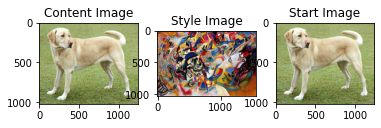

Epoch  0/10 (  0%) [.                   ] Time 0:00:00
Step 20/20 (100%) [....................] Time 0:00:19


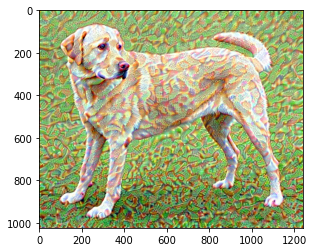

Epoch  1/10 ( 10%) [...                 ] Time 0:00:20
Step 40/40 (100%) [....................] Time 0:00:33


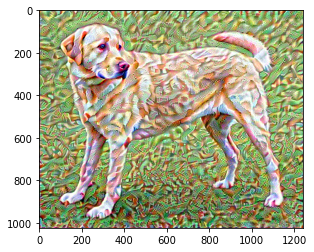

Epoch  2/10 ( 20%) [.....               ] Time 0:00:55
Step 60/60 (100%) [....................] Time 0:00:50


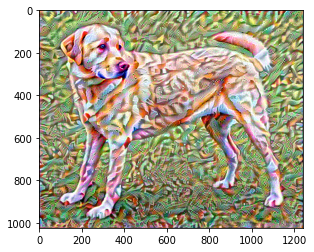

Epoch  3/10 ( 30%) [.......             ] Time 0:01:47
Step 80/80 (100%) [....................] Time 0:01:07


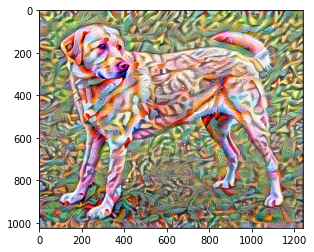

Epoch  4/10 ( 40%) [.........           ] Time 0:02:55
Step 100/100 (100%) [....................] Time 0:01:25


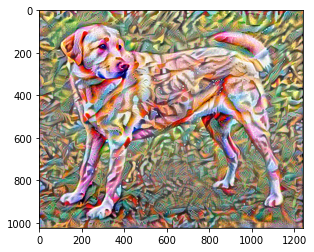

Epoch  5/10 ( 50%) [...........         ] Time 0:04:21
Step 120/120 (100%) [....................] Time 0:01:41


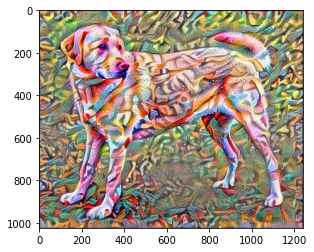

Epoch  6/10 ( 60%) [.............       ] Time 0:06:04
Step 140/140 (100%) [....................] Time 0:01:58


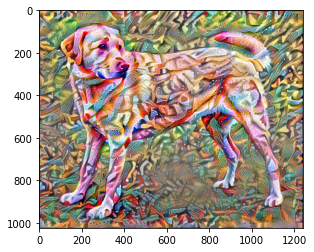

Epoch  7/10 ( 70%) [...............     ] Time 0:08:04
Step 160/160 (100%) [....................] Time 0:02:15


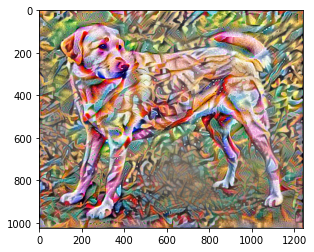

Epoch  8/10 ( 80%) [.................   ] Time 0:10:20
Step 180/180 (100%) [....................] Time 0:02:32


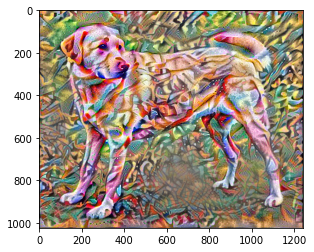

Epoch  9/10 ( 90%) [................... ] Time 0:12:54
Step 200/200 (100%) [....................] Time 0:02:49


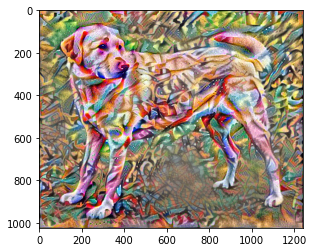

Epoch 10/10 (100%) [....................] Time 0:15:45
Combination 3/3 (100%) [--------------------------------------------------] Time 0:47:37


<Figure size 432x288 with 0 Axes>

In [12]:
import os
import src
from loadbar import RainbowBar
import IPython.display as display

content_path_list, style_path_list = src.st.data.get_data()
num_content = len(content_path_list)
num_style = len(style_path_list)
num_image_start = src.st.data.get_num_image_start(num_content, num_style)
num_params = src.st.var.param.length
nb_combinations = num_content * num_style * num_image_start * num_params
print(f'{nb_combinations} combinations ({num_content} contents, {num_style} styles, {num_image_start} starts, {num_params} params)')
bar = RainbowBar( max=nb_combinations, size=50, head='>', body='-', title='Combination', show_time=True)
bar.start()
for i in range(nb_combinations):
  if i > 0: display.clear_output(wait=True)
  # I launch a different process to solve the leak memory issue in tensorflow.
  # When the process is finished, at least everything about this one is cleaned and I can start again peacefully
  # and there is no memory issue anymore :)
  bar.update(step=i, end='\n')
  %run style_transfert.py
  if not all_images:
    # Do only one image
    break
bar.end()

# Save and download

In [13]:
# Zip it
!zip -r results.zip results

  adding: results/ (stored 0%)
  adding: results/p1.txt (deflated 52%)
  adding: results/p2.txt (deflated 52%)
  adding: results/p0.txt (deflated 52%)
  adding: results/parameters.txt (deflated 52%)
  adding: results/YellowLabradorLooking_new/ (stored 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/ (stored 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/p1_(content)_YellowLabradorLooking_new_step_200.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/p2_(content)_YellowLabradorLooking_new_step_420.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/p0_(content)_YellowLabradorLooking_new_step_720.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/p0_(content)_YellowLabradorLooking_new_step_20.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/p2_(content)_YellowLabradorLooking_new_step_560.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/p1_(content)_Yell

In [14]:
# Download it
from google.colab import files


is_downloaded = False
i = 0
while not is_downloaded:
  try:
    files.download('results.zip')
    is_downloaded = True
  except Exception as e:
    i += 1
    print(i, e)
  if i == 100:
    print('Could not download')
    break

# If this part doesn't work, see the section "To allow the download" at the beginning

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

End :)